# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

100%|██████████| 170M/170M [00:09<00:00, 18.5MB/s]


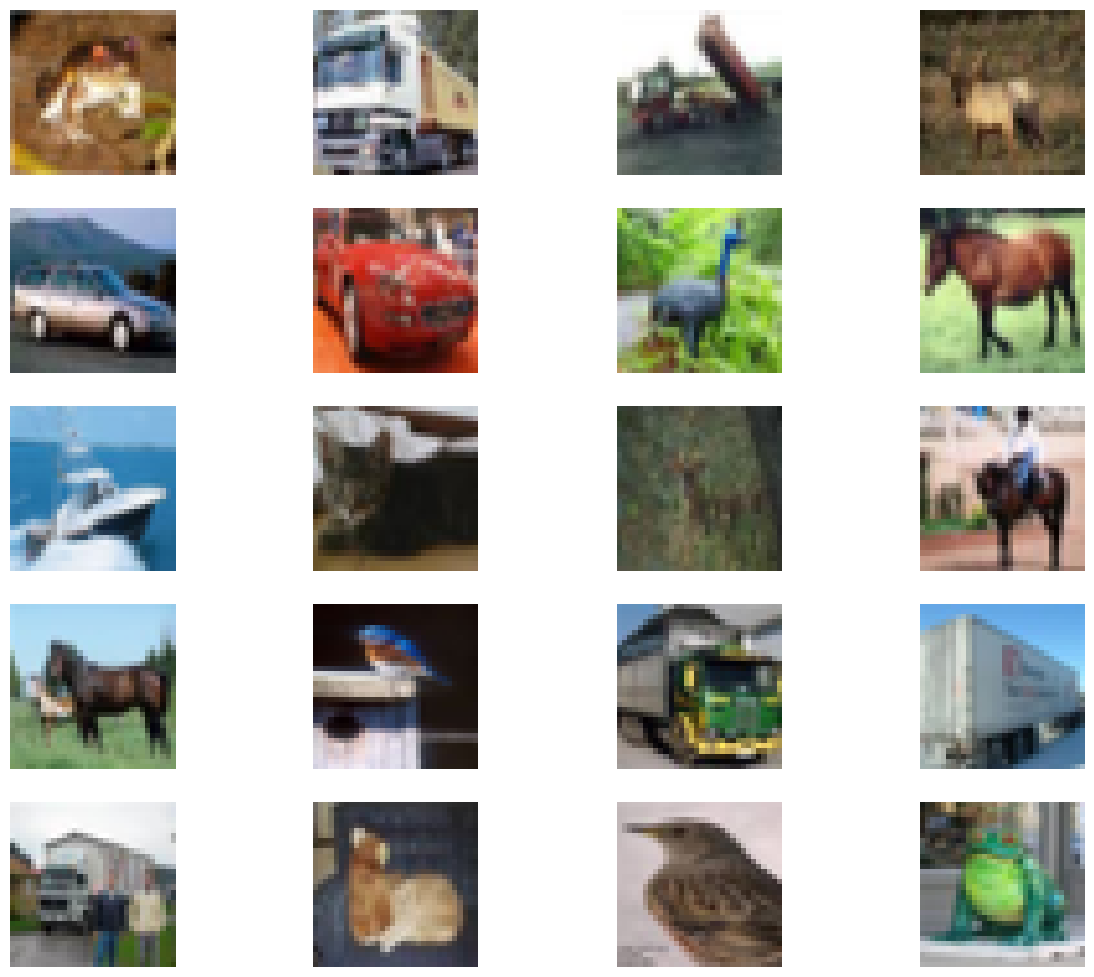

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

# StanfordCars 데이터셋 오류로 CIFAR-10 사용

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0].permute(1, 2, 0))
        plt.axis("off")

# Data distribution p(x₀)
# DDPM 모델이 학습할 원본 데이터 분포를 시각적으로 확인

data = torchvision.datasets.CIFAR10(root=".", download=True, transform=torchvision.transforms.ToTensor())
show_images(data)

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect.

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [4]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    # DDPM 논문 Section 2.3: β₁ ~ β_T는 각 step마다 추가되는 noise의 분산 크기를 조절
    # Linear schedule: β_t를 0.0001~0.02 사이 선형 증가로 설정하여 점진적 노이즈 주입
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    # 각 배치 샘플별 timestep t에 해당하는 ᾱₜ, βₜ 등의 계수를 선택
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    # ᾱₜ는 t까지의 노이즈 누적 비율, ε ~ N(0, I)는 Gaussian noise
    # 즉, t단계의 noisy image를 폐형식(closed-form)으로 계산
    # mean: sqrt(ᾱₜ)x₀  /  variance: (1-ᾱₜ)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
# β₁~β_T는 노이즈 주입 강도. 너무 크면 이미지가 급격히 파괴됨
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
# αₜ = 1 - βₜ  (각 step에서 유지되는 신호 비율)
alphas = 1. - betas
# ᾱₜ = ∏ₛ₌₁ᵗ αₛ  (t까지 누적된 신호 비율)
alphas_cumprod = torch.cumprod(alphas, axis=0)
# ᾱ_{t-1}을 구하기 위한 이전 단계 누적 α 값
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
# 1/√αₜ (reverse process 계산 시 사용)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
# √ᾱₜ (forward process의 평균 항)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
# √(1-ᾱₜ) (forward process의 노이즈 항)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
# q(x_{t-1} | xₜ, x₀)의 분산 항; Reverse process에서 샘플링 시 사용됨
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset ...

In [7]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    # DDPM 논문에서 p(x₀)는 실제 데이터 분포를 의미
    # 이를 모델 입력에 적합하도록 정규화하고 augmentation 수행
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
     ]  # 모델 입력으로 정규화된 데이터를 사용하여 수렴 안정화 유도

    data_transform = transforms.Compose(data_transforms)

    # 샘플링된 데이터를 기반으로 q(xₜ|x₀) 생성 과정 학습
    train = torchvision.datasets.CIFAR10(
        root=".",
        download=True,
        transform=data_transform,
        train=True
    )

    test = torchvision.datasets.CIFAR10(
        root=".",
        download=True,
        transform=data_transform,
        train=False
    )

    # 논문에서는 대규모 데이터 분포 p(x₀)에서 샘플링한다고 가정하므로 train/test를 합쳐 전체 분포를 근사
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    # 학습 중 [-1, 1]로 스케일된 이미지를 다시 [0, 255]로 복원해 시각화
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

# DDPM 학습의 입력 p(x₀) ~ data distribution
data = load_transformed_dataset()
# 모델이 매 iteration마다 p(x₀)에서 배치 샘플링하여 Forward Diffusion을 통해 q(xₜ|x₀)를 계산하고 loss를 구함
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

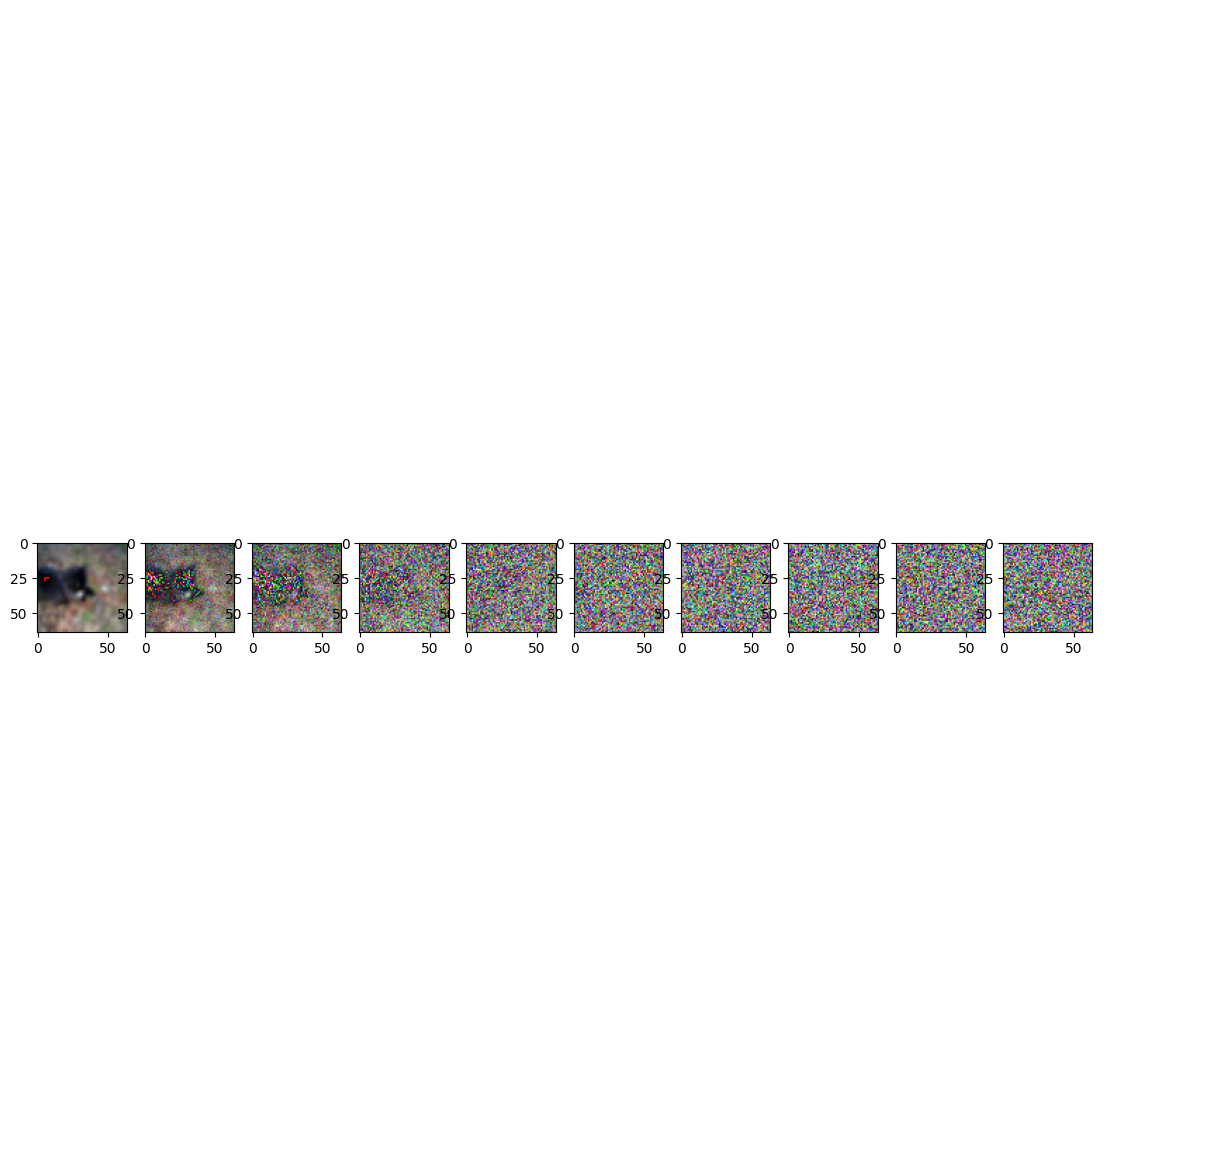

In [8]:
# 원본 이미지 x₀에 β-schedule에 따라 점진적으로 Gaussian noise를 추가해 t이 커질수록 pure noise에 가까워지는 과정을 시각화함
image = next(iter(dataloader))[0]

# 데이터 분포 p(x₀)에서 한 배치의 이미지를 샘플링
# forward_diffusion_sample()을 통해 각 timestep t에서의 xₜ 생성

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    # forward_diffusion_sample()을 통해 t단계의 noisy image 계산
    img, noise = forward_diffusion_sample(image, t)
    # t이 커질수록 이미지가 점점 파괴되어 Gaussian noise에 가까워짐
    show_tensor_image(img)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [9]:
from torch import nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # 첫 번째 Conv 블록
        h = self.bnorm1(self.relu(self.conv1(x)))
        # timestep 정보를 반영한 time embedding
        time_emb = self.relu(self.time_mlp(t))
        # 시간 차원을 공간 차원으로 확장
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # feature map에 시간 정보 추가
        h = h + time_emb
        # 두 번째 Conv 블록
        h = self.bnorm2(self.relu(self.conv2(h)))
        # up=False면 Downsampling, up=True면 Upsampling 수행
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # Sinusoidal position encoding (Transformer와 동일한 방식)
        # timestep t를 임베딩 벡터로 변환하여 모델이 시간 정보를 학습할 수 있게 함
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # timestep 정보를 위한 embedding 네트워크
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # 입력 이미지 초기 projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsampling 경로 (encoding)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1],
                                    time_emb_dim)
                    for i in range(len(down_channels)-1)])

        # Upsampling 경로 (decoding)
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1],
                                        time_emb_dim, up=True)
                    for i in range(len(up_channels)-1)])

        # 출력층: 예측된 noise ε̂ (xₜ와 동일한 차원)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # timestep을 임베딩 벡터로 변환
        t = self.time_mlp(timestep)
        # 초기 Conv
        x = self.conv0(x)
        # Downsampling 경로에서 feature 추출
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        # Upsampling 경로에서 skip connection을 이용해 복원
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # skip connection으로 feature 결합
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        # 최종적으로 노이즈 ε̂ 예측
        return self.output(x)

# 모델 초기화
model = SimpleUnet()
# 파라미터 수 출력
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [10]:
def get_loss(model, x_0, t):
    # 원본 이미지 x₀에 timestep t에 해당하는 노이즈를 추가
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    # 모델이 noisy image xₜ와 timestep t를 입력받아 노이즈 ε̂를 예측
    noise_pred = model(x_noisy, t)
    # 실제 노이즈 ε와 예측 노이즈 ε̂의 차이를 L1 Loss로 계산
    # DDPM의 학습 목표는 ε̂ ≈ ε 이 되도록 하는 것
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [11]:
@torch.no_grad()
def sample_timestep(x, t):
    # DDPM의 Reverse process: xₜ → xₜ₋₁ 로 복원하는 단계
    # 모델이 예측한 노이즈를 이용해 이미지에서 노이즈를 제거함

    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # 모델이 예측한 노이즈(ε̂)를 이용해 복원된 이미지(mean) 계산
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # 마지막 스텝에서는 더 이상 노이즈를 추가하지 않음
        return model_mean
    else:
        # 아직 중간 단계이면 다음 xₜ₋₁ 샘플을 위해 랜덤 노이즈 추가
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def sample_plot_image():
    # DDPM의 Reverse diffusion 전체 시각화
    # 랜덤 노이즈 x_T에서 시작해 반복적으로 xₜ₋₁을 생성하며 원본 이미지로 복원

    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0, T)[::-1]:
        # timestep을 역순으로 진행 (T → 0)
        t = torch.full((1,), i, device=device, dtype=torch.long)
        # 각 스텝에서 노이즈를 제거하며 이미지 복원
        img = sample_timestep(img, t)
        # 이미지 값 범위를 [-1, 1]로 유지
        img = torch.clamp(img, -1.0, 1.0)
        # 일정 간격으로 복원 과정을 시각화
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## Training

Epoch 0 | step 000 Loss: 0.8129639625549316 


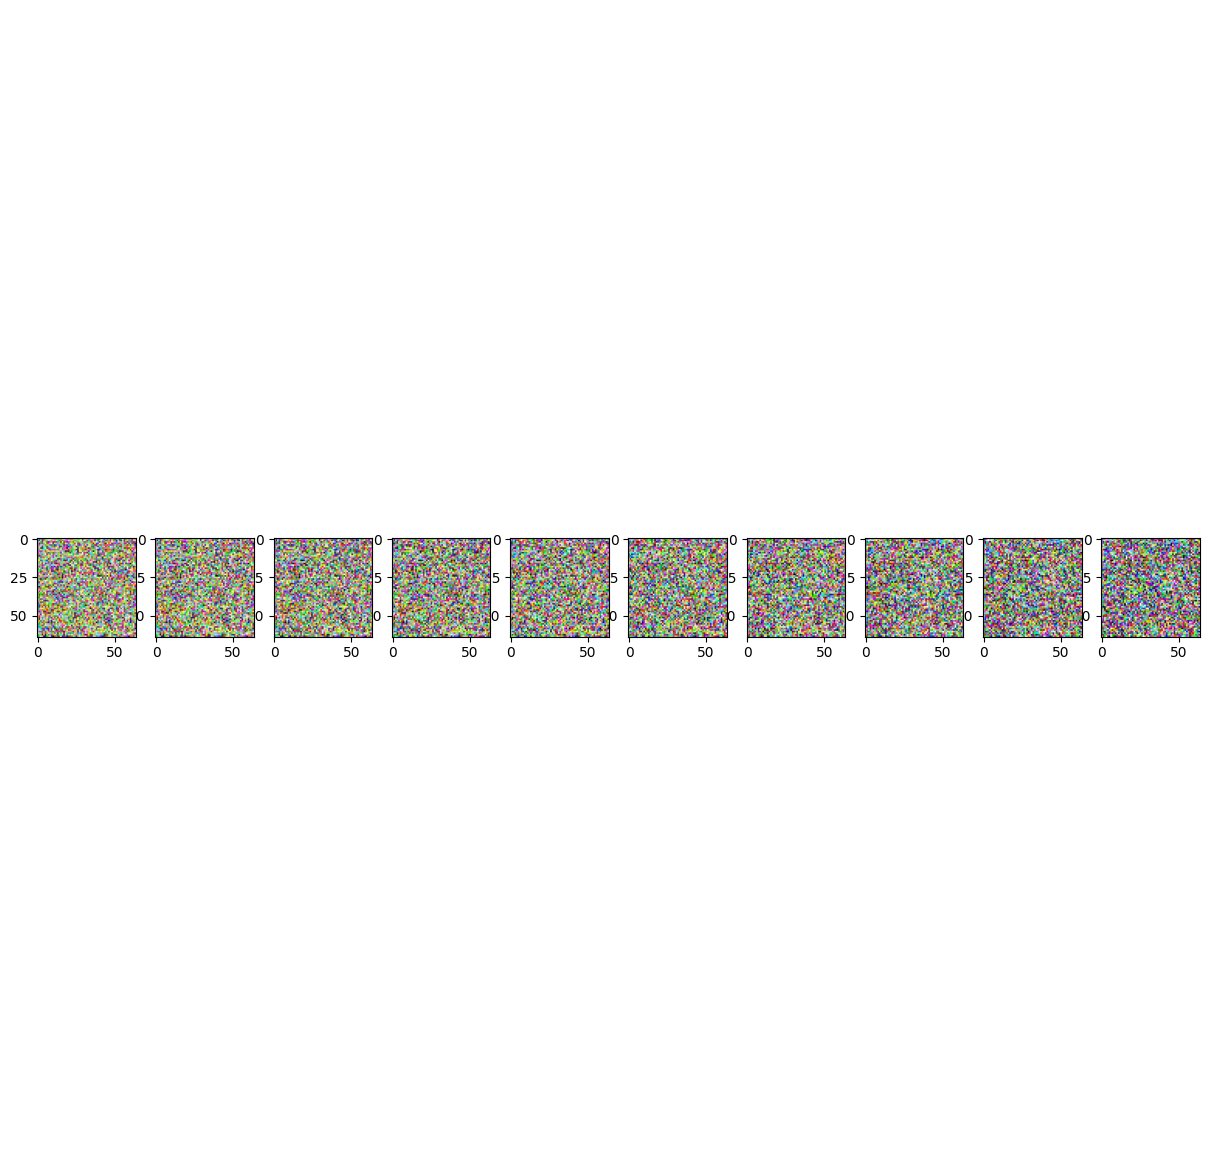

KeyboardInterrupt: 

In [12]:
from torch.optim import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Adam optimizer 초기화
optimizer = Adam(model.parameters(), lr=0.001)

# 학습 epoch 수
epochs = 100  # 더 긴 학습 시 품질 향상 가능

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        # 각 배치에 대해 임의의 timestep t 선택
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

        # Forward diffusion을 적용한 noisy image와
        # 모델이 예측한 noise 간의 차이를 기반으로 loss 계산
        loss = get_loss(model, batch[0], t)

        # 역전파로 모델 파라미터 업데이트
        loss.backward()
        optimizer.step()

        # 일정 주기마다 학습 상태 출력 및 이미지 샘플 시각화
        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()